# (APERTAR O BOTÃO ACIMA PARA VER O CÓDIGO)

# Relatório Cluster - Nicholas Richers

In [1]:
#bibliotecas utilizadas
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load libraries and set plot parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 12

# Preparação dos Dados:

Utilizando o mesmo dataset já preparado no relatório market basket:
* Haviam 18 filmes com Id duplicado, que foram removidos
* A alteração dos filmes do Id duplicado gerou 522 notas duplicadas (i.e mesmo usuario dando nota pro mesmo filme) (261 foram removidas)

In [35]:
from setup_database import setup_BD, setup_results, get_genre

#carregando os datasets de ratings
original_ratings_100k = pd.read_csv('./ml-100k/u.data', header=None, delimiter="\t" )
original_ratings_1M = pd.read_csv('./ml-1m/ratings.dat', header=None, delimiter=":" )


#carregando os datasets de filmes
original_movies_100k = pd.read_csv('./ml-100k/u.item', header=None, sep='|' , encoding='latin-1')
original_movies_1M = pd.read_csv('./ml-1m/movies.dat', header=None, sep=';' , encoding='latin-1')


#obter os datasets limpos
rat_100k, mov_100k = setup_BD(original_ratings_100k, original_movies_100k)
rat_1M, mov_1M = setup_BD(original_ratings_1M, original_movies_1M)

## Análise Exploratória (Dataset 100k)

Através do __Gráfico Boxplot__ abaixo, temos algumas informções interessantes como a __média de 106 filmes assistidos por usuário__, com uma máximo de 737.

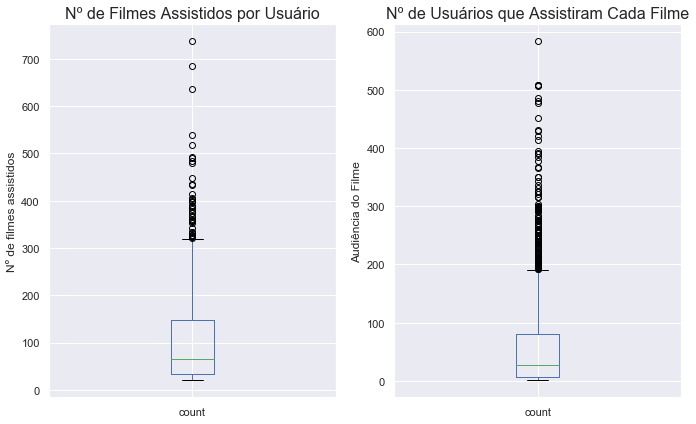

Descrição dos Filmes por Usuário


,count,mean,std,min,25%,50%,75%,max
count,943.0,106.044539,100.931743,20.0,33.0,65.0,148.0,737.0


In [4]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
Users_Count_100k = rat_100k.groupby('User_Id').Rating.agg(['count'])
Users_Count_100k.boxplot()
plt.title("Nº de Filmes Assistidos por Usuário")
plt.ylabel("Nº de filmes assistidos")


plt.subplot(1,2,2)
Movies_Count_100k = rat_100k.groupby('Movie_Id').Rating.agg(['count'])
Movies_Count_100k.boxplot()
plt.title("Nº de Usuários que Assistiram Cada Filme")
plt.ylabel("Audiência do Filme")


plt.tight_layout()
plt.show()

print("Descrição dos Filmes por Usuário")
Users_Count_100k.describe().T

O __filme mais assistido__ com aproximadamente __600 visualizações__, porém a mdeiana de visualizações é de apenas 27 filmes, o que indica que teremos um vetor de notas extremamente esparço, o que favorece o uso de alguma tecnica de redução de dimensionalidade. 

In [5]:
print("Usuários Por Filme")
Movies_Count_100k.describe().T

Usuários Por Filme


,count,mean,std,min,25%,50%,75%,max
count,1682.0,59.453032,80.383846,1.0,6.0,27.0,80.0,583.0


### Valores Nulos

A fim de __evitar valores nulos__ no vetor de notas do filme vamos vamos __substituir__ os valores nulos __pela média__ das outras notas recebidas pelo filme.
* Obs: Cabe ressaltar que essa medida deverá __introduzir um viés nos seus dados__, especialmente na __variância__

In [6]:
def fill_na(ratings):
    #cria a tabela Movie_Id X User_Id
    ratings_pivot = ratings.pivot(index='Movie_Id', columns='User_Id', values='Rating')

    #média das notas de cada filme
    Mean_Rating = ratings_pivot.mean(axis=1)

    #preenche a tabela com as médias
    ratings_pivot = ratings_pivot.T.fillna(Mean_Rating).T
    
    return ratings_pivot

Tabela __Movie_Id X User_Id__, preenchida com as notas de cada filme

In [7]:
ratings_1M = fill_na(rat_1M)
ratings_100k = fill_na(rat_100k)
ratings_100k.head()

User_Id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
Movie_Id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.000000,3.878319,3.878319,4.000000,4.000000,3.878319,3.878319,3.878319,4.000000,...,2.000000,3.000000,4.000000,3.878319,4.000000,3.878319,3.878319,5.000000,3.878319,3.878319
2,3.0,3.206107,3.206107,3.206107,3.000000,3.206107,3.206107,3.206107,3.206107,3.206107,...,4.000000,3.206107,3.206107,3.206107,3.206107,3.206107,3.206107,3.206107,3.206107,5.000000
3,4.0,3.033333,3.033333,3.033333,3.033333,3.033333,3.033333,3.033333,3.033333,3.033333,...,3.033333,3.033333,4.000000,3.033333,3.033333,3.033333,3.033333,3.033333,3.033333,3.033333
4,3.0,3.550239,3.550239,3.550239,3.550239,3.550239,5.000000,3.550239,3.550239,4.000000,...,5.000000,3.550239,3.550239,3.550239,3.550239,3.550239,2.000000,3.550239,3.550239,3.550239
5,3.0,3.302326,3.302326,3.302326,3.302326,3.302326,3.302326,3.302326,3.302326,3.302326,...,3.302326,3.302326,3.302326,3.302326,3.302326,3.302326,3.302326,3.302326,3.302326,3.302326


__Análise__ Descritiva das __Notas__ recebida por cada __filme__ (coluna). É interessante observar que há alguns __filmes assistidos apenas uma vez__, logo o __preenchimento do vetor de notas__ desse filme não irá causar __nenhuma alterção__.

In [8]:
ratings_100k.T.describe()

Movie_Id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
count,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,...,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0
mean,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
std,0.642041,0.359043,0.372773,0.453487,0.284302,0.212022,0.632690,0.482161,0.586278,0.309907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
25%,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
50%,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
75%,4.000000,3.206107,3.033333,3.550239,3.302326,3.576923,4.000000,3.995434,3.896321,3.831461,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0


# Treinamento dos Modelos (Parte I)

## K-Means

In [9]:
from sklearn.cluster import KMeans
from spherecluster import SphericalKMeans
import time
import warnings
warnings.filterwarnings('ignore')

def scores_kmeans(data,n_try=10):
    wcss, time_elapsed = [], []

    clusters_range = np.linspace(5,20,num=n_try)
    for n in clusters_range:
        
        
        #algoritmo k-means com distancia euclidiana
        start1 = time.time()
        kmeans =KMeans(n_clusters = int(n), init = 'random').fit(data)
        elapsed_time1 = time.time() - start1
        
        
        #Spherical kmeans (similar cosine distance)
        start_time2 = time.time()
        skm = SphericalKMeans(n_clusters= int(n)).fit(data)
        elapsed_time2 = time.time() - start_time2

        
        #lista dos scores e tempo
        wcss.append((kmeans.inertia_/n ,skm.inertia_/n))
        time_elapsed.append((elapsed_time1, elapsed_time2))


    #plotando os gráficos Scores(EUC) X Nº de Clusters   
    plt.figure(figsize=(12, 8))
    plt.subplot(3,1,1)
    wcss = np.array(wcss)
    plt.plot(clusters_range, wcss[:,0])
    plt.title('O Metodo Elbow')
    plt.ylabel('WCSS - Euclidean') #within cluster sum of squares
    
    
    #plotando os gráficos Scores(SPH) X Nº de Clusters   
    plt.subplot(3,1,2)
    plt.plot(clusters_range, wcss[:,1], c='orange')
    plt.ylabel('WCSS - Spherical')

    
    #plotando os gráficos tempo X Nº de Clusters 
    plt.subplot(3,1,3)
    plt.plot(clusters_range, time_elapsed)
    plt.xlabel('Numero de Clusters')
    plt.ylabel("Time_elapsed (s)")

    #plt.tight_layout()
    plt.show()


__(Dataset 100k)__ A fim de __invenstigar o número de clusters__, usamos o __método elbow__, que mede a _distância_ que cada amostra está de cada cluster, uma vez que essa medida para de dimunuir de maneira intensa, temos a formação de um cotovelo no gráfico, usando __distância euclidiana__, vemos que o score converge próximo a __8 Clusters__, já usando __distância cosseno__ apesar do comportamento similar, o __score diminui muito pouco__ sendo difícil dizer um número ideal de clusters.

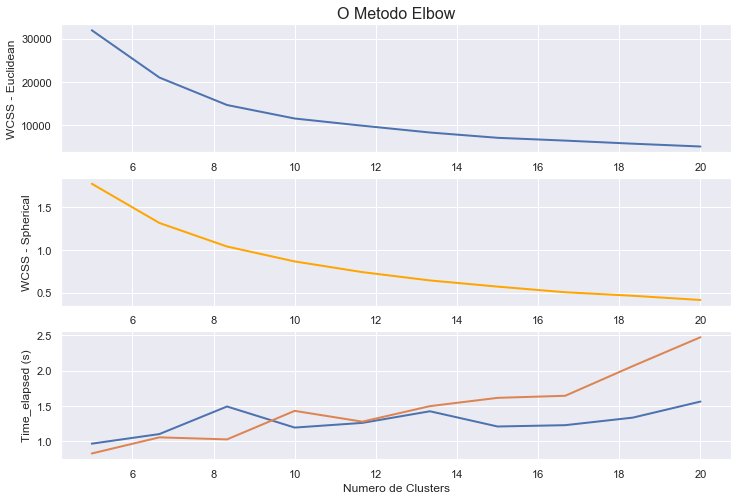

In [10]:
scores_kmeans(ratings_100k)

__(Dataset 1M)__ Para o dataset 1M, apenas de um aumento na ordem 1:10 no tempo computacional, encontramos um comportamento __semelhante ao dataset 100k__ em relação ao __score__, então, também usaremos __10 clusters__.

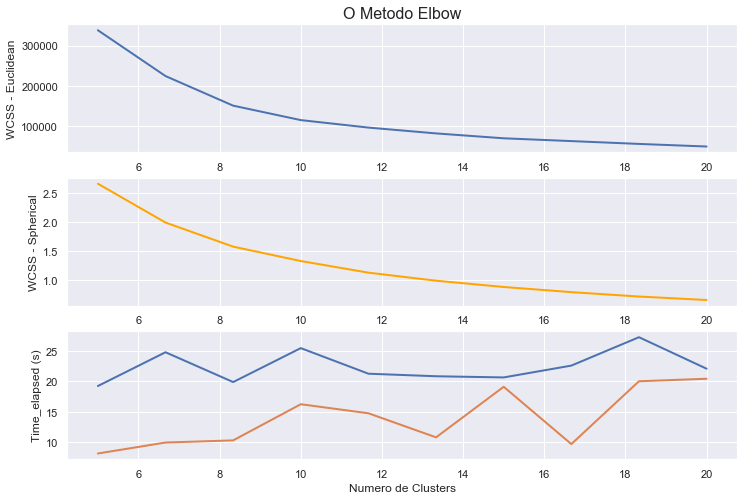

In [11]:
scores_kmeans(ratings_1M)

## DBSCAN

Uma outra alternativa para a tarefa de clusterização é usar o DBSCAN, esse algorimo tem a vantagem de não precisar indicar um número de clusters previamente, porém, houve difuldade na interpretação dos resultados especialmente por não haver uma função de avaliação específica no caso de um treinamento não supervisionado, de qualquer forma, pela imagem abaixo percebemos que há bastante ruído na amostra, que são os pontos em azul no gráfico.

Text(0, 0.5, 'Feature 1')

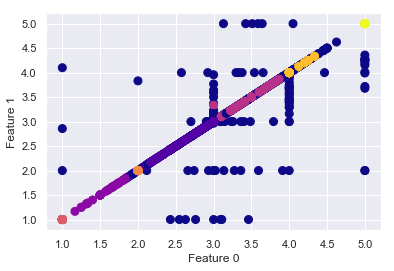

In [12]:
from sklearn.cluster import DBSCAN

# Treina o modelo
X = np.array(ratings_100k)
dbscan = DBSCAN(eps=4, min_samples = 5)
clusters = dbscan.fit_predict(X)

# plota o gráfico
plt.scatter(X[:, 1], X[:, 2], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# Treinamento dos Modelos (Parte II)

## Redução de dimensionalidade (PCA)

O PCA normalmente é utilizado para acelerar a convergência de um algortimo ou para __facilitar a visualização e a interpretação dos dados__, como no caso do presente estudo.

In [13]:
from sklearn.decomposition import PCA, KernelPCA

def plot_pca(data, dim_list = (3,3,3), plot = True):

    #dimensoes da figura
    sub_plot = range(131, 134)
    if plot==True: plt.figure(figsize=(15, 5))
    
    PcaComp = {}
    kernel_list = ("linear", "rbf", "sigmoid")
    for subplot, kernel, dim in zip(sub_plot, kernel_list, dim_list):

        #obtem as componentes do PCA
        Z_Comp = KernelPCA(n_components=dim,kernel=kernel,fit_inverse_transform=True).fit_transform(data)
        PcaComp[kernel] = Z_Comp
        
        
        
        #(%)Variancia explicada pelas componentes
        explained_var = np.var(Z_Comp, axis=0)
        explained_var_ratio = explained_var / np.sum(explained_var)
        explained_var_sum = np.cumsum(explained_var_ratio)*100

        if plot==True:
            #plotando as dimensoes 0 e 1 do PCA
            plt.subplot(subplot)
            plt.scatter(Z_Comp[:, 0], Z_Comp[:, 1])

            #labels do gráfico
            plt.title('Kernel {} | Dim:{} | Var: {:.1f}%'.format(kernel.capitalize(),dim, explained_var_sum[0]))
            plt.xlabel("$z_1$")
            if subplot == 131: plt.ylabel("$z_2$")


    plt.tight_layout
    plt.show()
    return PcaComp


No gráfico abaixo temos __três__ variações de __PCA__ acompanhados do numero de componentes (dimensão) e da variância dos dados explicada por essas componentes. A partir dos resultados podemos visualizar que o __kernel RBF__ possui uma disposição bastante interessante dos dados, porém a __variância explicada__ pelas componentes é siginificativamente mais __baixa__ que as outras e já se encontra no maior valor possível. Para o __kernel sigmoid__ não se chegou a __nenhuma disposição__ interessante dos dados, logo __não será utilizada__.

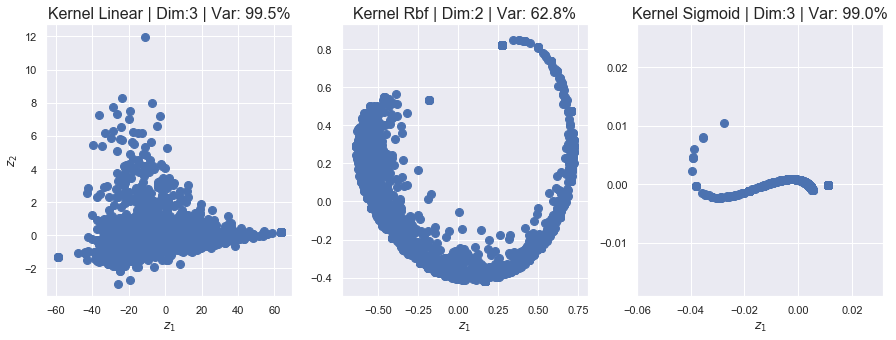

In [14]:
PCA_Comps = plot_pca(ratings_100k, dim_list = (3,2,3))

### Kmeans com PCA

Nessa etapa __testou-se__ o algoritmo __k-means__ usando __distância euclidiana__, para as __três__ configurações de __kernel__ já mencionandas. Os principais resultados serão comentados abaixo.

In [15]:
def kmeans_training(data, distance, kernel, dim_list = (3,3,3), clusters=10, plot=True):
    
    #Reduz a dimensionalidade do dataset
    PCA_Comps = plot_pca(data,dim_list, plot =False)
    
    #treina o modelo de acordo com o kernel utilizado
    if(distance == "spherical"): train = SphericalKMeans(n_clusters= clusters).fit(data)
    if(distance == "euclidean"): train = KMeans(n_clusters=clusters).fit(data)
    labels = train.labels_

    #adiciona os labels do treinamento no dataframe
    PCA_DF = pd.DataFrame(PCA_Comps[kernel])
    PCA_DF['labels'] = labels
    
    #remane columns
    if PCA_DF.shape[1]==3: 
        PCA_DF = PCA_DF.rename(mapper={0:'pca_0', 1:'pca_1'}, axis='columns')
        
    else:  
        PCA_DF = PCA_DF.rename(mapper={0:'pca_0', 1:'pca_1', 2:'pca_2'}, axis='columns')
    
    if plot==False: return PCA_DF
    
    #Cria o gráfico
    ax = sns.pairplot(PCA_DF, hue="labels", x_vars=PCA_DF.columns, y_vars=PCA_DF.columns)
    ax.fig.suptitle('KMeans "{}" | Kernel {} '.format(distance.capitalize(), kernel.capitalize()), fontsize=16)
    plt.show()

Analisando o gráfico pareado em 3 dimensões de PCA para o __Kmeans com distância euclidiana__ e __kernel linear__, pode-se dizer que visualmente o __resultado__ está __bastante aceitável__ para __8 clusters__, podendo ser confirmado por pelo menos 4 dimensões do gráfico.

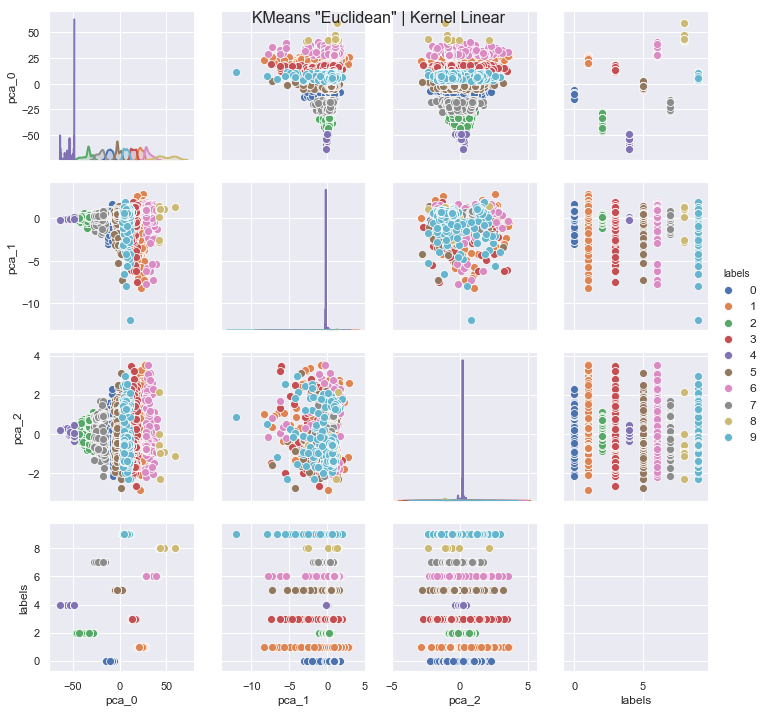

In [16]:
kmeans_training(ratings_100k, "euclidean", "linear")

Porém, utilizando o __kernel de base radial__, a disposição dos dados ficou ainda mais interesante. Porém há de se tomar alguns cuidados, pois da forma como está disposto, praticamente qualquer quantidade de clusters fornece uma base de separação bastante aceitável.

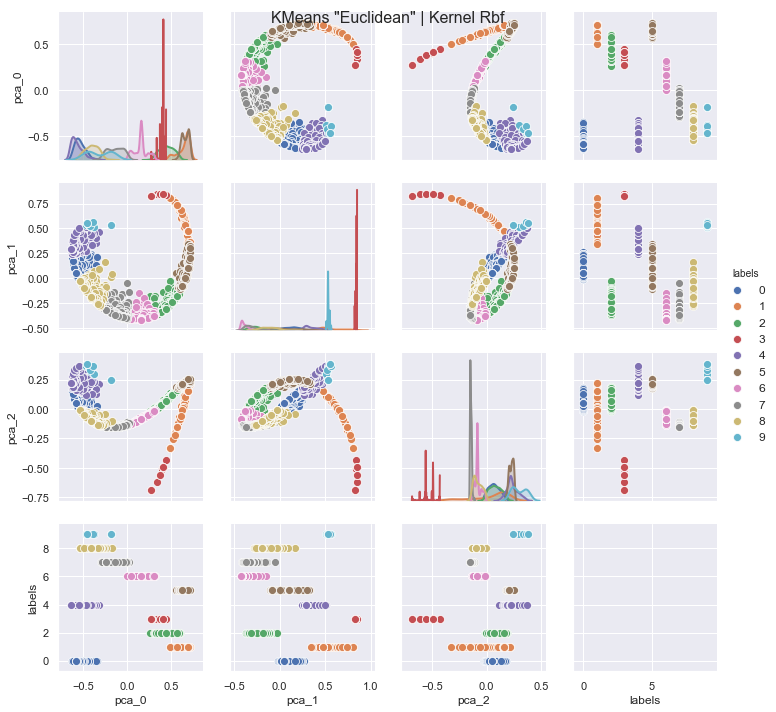

In [17]:
kmeans_training(ratings_100k, "euclidean", "rbf")

Por fim, para aproveitarmos o _spherical kmeans_ (distância cosseno), desenvolvido na seção anterior, plotamos o resultado usando o __kernel rbf__, porém como podemos ver, a __disposição dos dados__ nessa configuração __não permite__ que esse modelo chege a __resultados aceitáveis__.

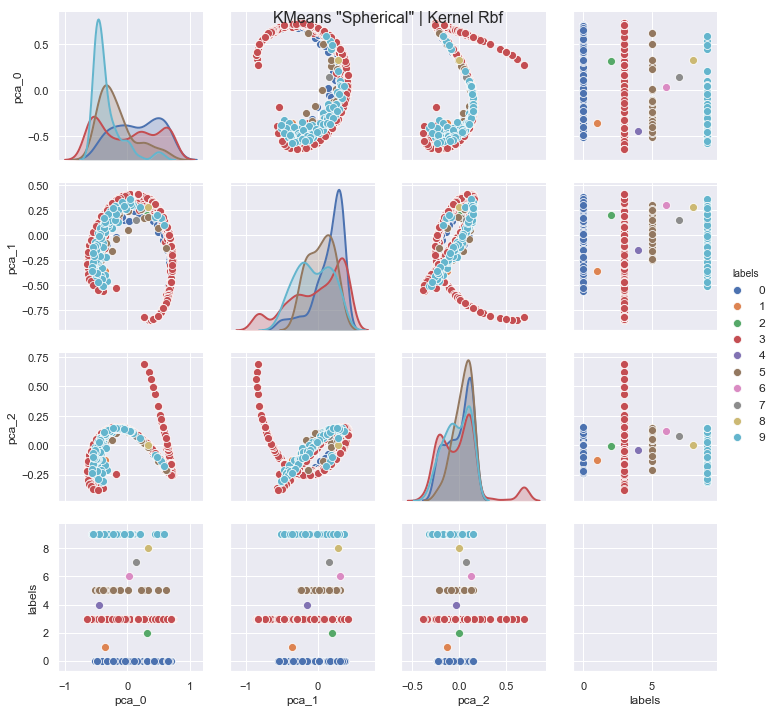

In [18]:
kmeans_training(ratings_100k, "spherical", "rbf")

### Kmeans com PCA (Dataset 1M)

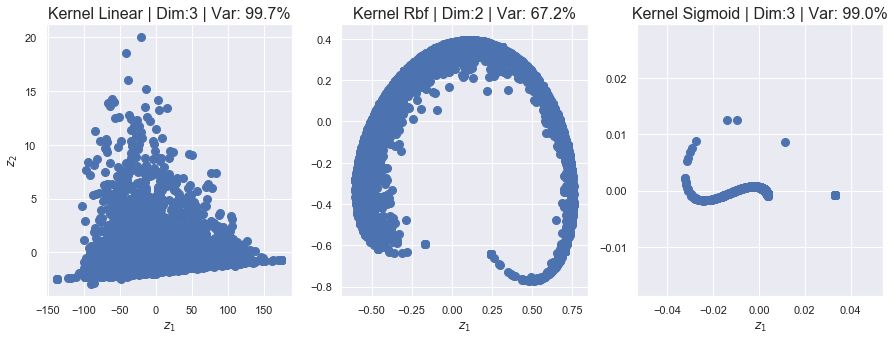

In [19]:
PCA_Comps = plot_pca(ratings_1M, dim_list = (3,2,3))

A disposição dos dados na imagem acima já demostra que apenas do adensamento, não houveram grandes mudanças na visualização dos dados. Como também ja era esperado, não houve (visualmente) uma mudança sigficativa na formação dos clusters nas duas configurações testadas.

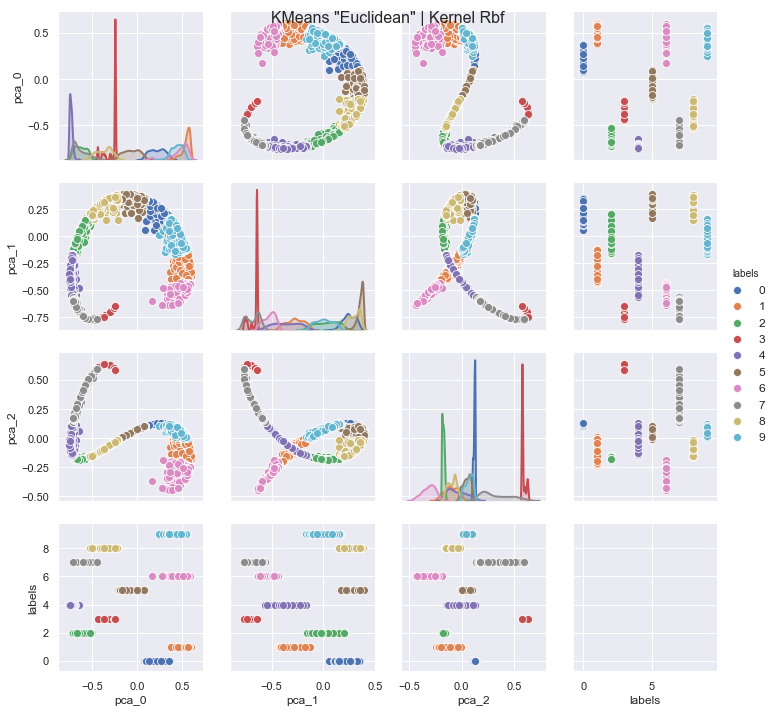

In [20]:
kmeans_training(ratings_1M, "euclidean", "rbf")

É interessante observar que o dataset maior permitiu um maior equilíbrio na distribuição dos dados, onde apenas um cluster (localizado na ponta), possui uma quantidade menos de dados, e pelo histoggrama (gráfico da diagonal principal), vemos uma margem de separação muito bem definida.

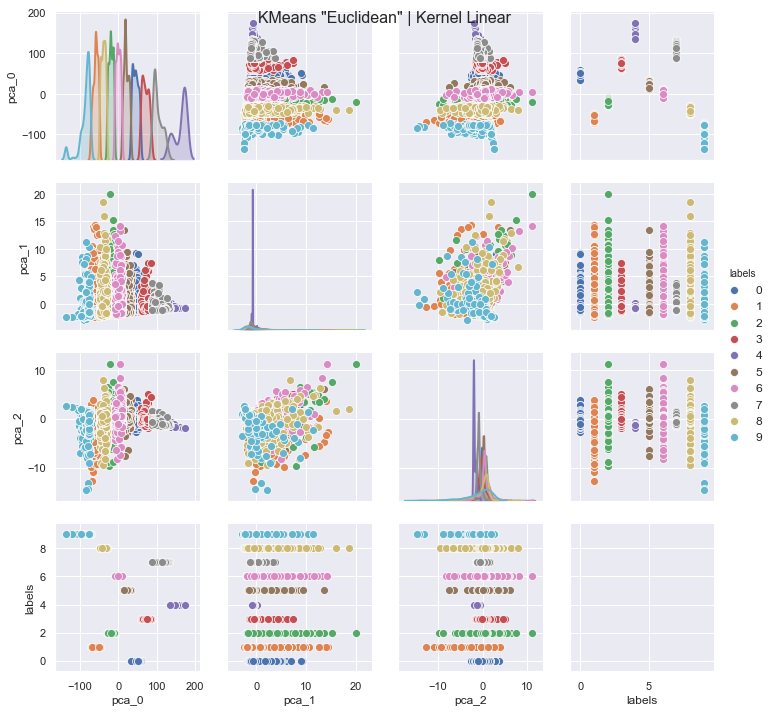

In [21]:
kmeans_training(ratings_1M, "euclidean", "linear")

## DBSCAN com PCA

Após os resultados ruins encontrados na parte 1, faremos uma nova tentativa com o algoritmo DBSCAN usando redução de dimensionalidade

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def DBScan_training(X, kernel, eps, min_samples, plot=True):

    #PCA
    PCA_Comps = plot_pca(X, dim_list = (3,3,3), plot =False)
    
    #feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    

    # treina o modelo
    dbscan = DBSCAN(eps, min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    #adiciona os labels do treinamento no dataframe
    PCA_DF = pd.DataFrame(PCA_Comps[kernel])
    PCA_DF['labels'] = labels
    
    if plot==False: return PCA_DF

   #plot the cluster assignments
    ax = sns.pairplot(PCA_DF, hue="labels", x_vars=PCA_DF.columns, y_vars=PCA_DF.columns)
    ax.fig.suptitle('DBSCAN | Kernel {} '.format(kernel.capitalize()), fontsize=16)
    plt.show()
    

De forma a realizar um ajuste de parâmetros, foram testadas todas as combinações listadas abaixo dos 2 parâmetros do DBSCAN. Os melhores resultados foram colocados abaixo.

In [23]:
print('Valores de Eps. Testados: {}'.format(np.logspace(-1.2,1.4,4)))
print('Min. Samples Testados: {}'.format(np.rint(np.linspace(2,10,4))))

Valores de Eps. Testados: [ 0.06309573  0.46415888  3.41454887 25.11886432]
Min. Samples Testados: [ 2.  5.  7. 10.]


A redução de dimensionalidade ajudou bastante na visualização, mas não ajudou muito no resultado final, na melhor configuração de parâmetro encontrada, aproximadamente __50% dos dados foram classificados como ruído__. Como lado positivo, destacamos que o algoritmo __encontrou os mesmos 10 clusters que o método elbow__ indicou. 

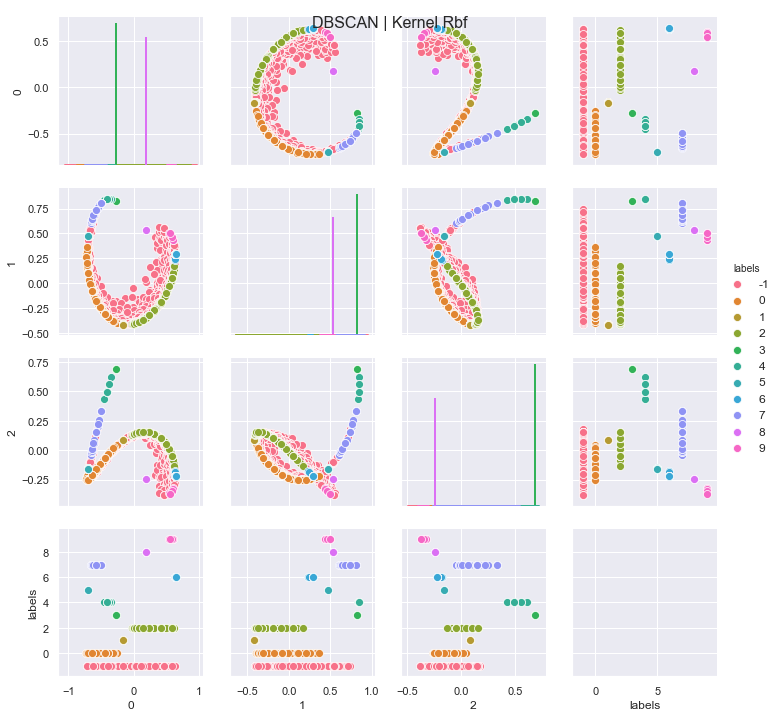

In [24]:
DBScan_training(ratings_100k, kernel= "rbf", eps=4, min_samples =5)

## DBSCAN com PCA (Dataset 1M)

Para o dataset 1M, usando a mesma configuração, o DBSCAN encontrou mais clusters, porém uma quantidade ainda maior de ruído.

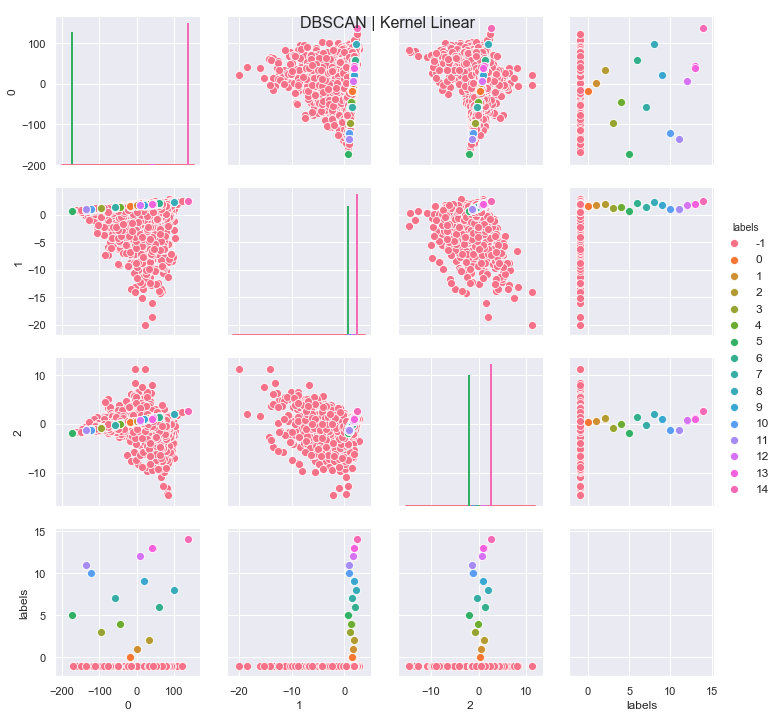

In [25]:
DBScan_training(ratings_1M, kernel= "linear", eps=4, min_samples =5)

Uma forma de tentar dimuir a quantidade de ruído encontrada é aumentar o EPS, porém acabamos encontrando um único cluster, o que não ajudaria em nada a análise.

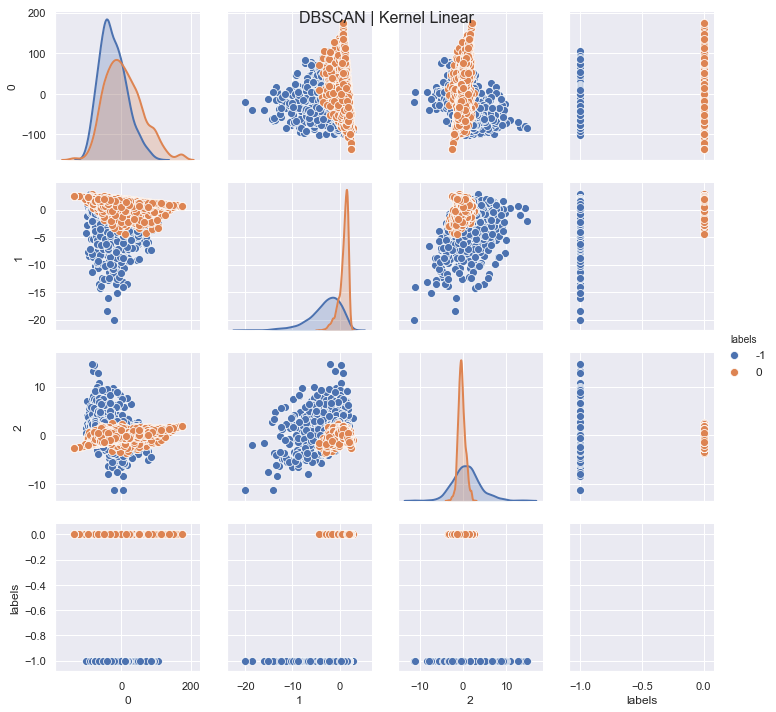

In [26]:
DBScan_training(ratings_1M, kernel= "linear", eps=25, min_samples =10)

# Análise dos Clusters (Dataset 100k)

Devido a __performance ruim__ do algoritmo __DBscan__ em todos os casos, __limitaremos a interpretação__ dos clusters, aos encontrados pelo algoritmo __kmeans__ usando o __PCA Linear__.

In [28]:
from sklearn.metrics import silhouette_score, silhouette_samples
def calculate_silhouette_for_clusters(df_pca, labels, metric='euclidean'):
    silhouete = silhouette_samples(df_pca, labels, metric=metric)
    d = {'labels': labels, 'silhouete': silhouete}
    temp_df = pd.DataFrame(d)
    return temp_df.groupby(['labels']).mean()

In [27]:
orig100k = original_movies_100k[:]
PCA_100k =  kmeans_training(ratings_100k, "euclidean", "linear", dim_list = (3,2,3), plot=False)
results_100k = setup_results(mov_100k, rat_100k, ratings_100k,  PCA_100k)
results_100k = get_genre(original_movies_100k, results_100k)
results_100k.head()

,Movie_Id,Movie,genre 1,genre2,Rating,Views,labels
0,1,Toy Story (1995),Animation,Children's,3.878319,452,2
1,2,GoldenEye (1995),Action,Adventure,3.206107,131,0
2,3,Four Rooms (1995),Thriller,None,3.033333,90,0
3,4,Get Shorty (1995),Action,Comedy,3.550239,209,5
4,5,Copycat (1995),Crime,Drama,3.302326,86,5


A primeira análise mostra que os filmes ficaram __quantitativamente bem distribuídos__, quase sempre em torno de 150 e 250 filmes, e apenas o cluster 3 apresentou um resultado inferior.

In [29]:
results_100k.groupby('labels').Movie.agg(['count']).T

labels,0,1,2,3,4,5,6,7,8,9
count,325,113,242,73,179,265,21,211,215,38


Em seguida usamos a métrica _silhouette_ encontrada na literatura como uma medida de coesão entre os clusters, aqui vemos que apenas o cluster 4 apresentou um resultado forte (o ideal é proximo a 1), e o cluster 3 como esperado foi o menos coeso, chamam atenção também os clusters 8 e 6, que apesar de estartem entre os maiores apresentaram também uma coesão baixa, o que pode indicar que eles contém muito ruído.

In [30]:
count = results_100k.groupby('labels').Rating.agg(['count'])
silhouette = calculate_silhouette_for_clusters(PCA_100k, results_100k['labels'])
count.merge(silhouette, on='labels').sort_values('silhouete', ascending = False).T

labels,3,1,9,7,0,8,4,6,2,5
count,73.000000,113.000000,38.000000,211.000000,325.000000,215.000000,179.000000,21.000000,242.000000,265.000000
silhouete,0.964455,0.657841,0.624548,0.590026,0.586969,0.568335,0.540536,0.499133,0.495728,0.492793


Extendendo nossa análise, vemos que o __cluster 3__ possui em médias os filmes __mais bem avaliados__, sendo esse mais um indicativo da presença de outliers nesse clustes (suspeita-se que são filmes vistos apenas uma vez). O __cluster 4__ por sua vez, que era o de __maior coesão__ representa os filmes com __pior avalição__. 

In [31]:
results_100k.groupby('labels').Rating.agg(['mean']).sort_values('mean', ascending = False).T

labels,6,8,2,5,0,7,4,1,9,3
mean,4.733257,4.057838,3.72921,3.426003,3.094279,2.774637,2.436361,2.038244,1.592836,1.009132


Ao __contrário__ do que se pensava anteriormente, na verdade é o __cluster 4__ que possui os __filmes menos vistos__ com uma média de apenas 1.84, já o cluster 3 apesentou um resultado intermediário.

In [32]:
results_100k.groupby('labels').Views.agg(['mean']).sort_values('mean', ascending = False).T

labels,8,2,5,6,0,7,4,1,9,3
mean,115.176744,108.892562,74.671698,55.0,45.009231,37.075829,21.586592,11.353982,6.210526,1.479452


Como há alguma dificuldade de se obter alguma respota coesa de algum cluster do início ao fim, vamos analisar os clusters individualmente a fim de enchergar algum padrao, os principais comentários são:

Cluster 0, 5, 6 e 9: Nenhuma interpretação.
Cluster 1: Muitos filmes de Drama, com muitas visualizações.
Cluster 2: Filmes de Horror com poucas visualizações.
Cluster 3: Filmes de ação e comédia com +- 50 visualizações.
Cluster 4: Filmes de drama e comédia com +- 100 visualizações
Cluster 7: Filmes de Ação e Infantis
Cluster 8 : Filmes de drama com mais de 300 views

In [67]:
r = results_100k.loc[:, ['Movie', 'genre 1',  'Views']]
for i in range(11):
    print('label: {}\n {}\n\n\n'.format(i, r[results_100k.labels == i].head(5)))

label: 0
                                  Movie   genre 1  Views
1                     GoldenEye (1995)    Action    131
2                    Four Rooms (1995)  Thriller     90
15  French Twist (Gazon maudit) (1995)    Comedy     39
16          From Dusk Till Dawn (1996)    Action     92
26                     Bad Boys (1995)    Action     57



label: 1
                                        Movie    genre 1  Views
34   Free Willy 2: The Adventure Home (1995)  Adventure     11
35                           Mad Love (1995)      Drama     13
102           All Dogs Go to Heaven 2 (1996)  Animation     15
262                             Steel (1997)     Action     19
351                       Spice World (1997)     Comedy     26



label: 2
                       Movie    genre 1  Views
0          Toy Story (1995)  Animation    452
6     Twelve Monkeys (1995)      Drama    392
8   Dead Man Walking (1995)      Drama    299
9        Richard III (1995)      Drama     89
10     Seven (Se7en)

## Análise dos clusters (Dataset 1M)

Agora vamos estender a análise para o dataset 1M, e vamos verificar se houve uma interpretação diferente no resultado obtido. O número de clusters não foi alterado a fim de perceber essas diferenças na interpretação.

In [59]:
orig1M = original_movies_1M[:]
PCA_1M =  kmeans_training(ratings_1M, "euclidean", "linear", dim_list = (3,2,3), plot=False)
results_1M = setup_results(mov_1M, rat_1M, ratings_1M,  PCA_1M)
original_movies_1M.columns = ['Movie_Id','movie_title', 'genre']
results_1M = results_1M.merge(original_movies_1M, on='Movie_Id')
results_1M.head()

,Movie_Id,Movie,Rating,Views,pca_0,pca_1,pca_2,labels,movie_title,genre
0,1,Toy Story (1995),4.146846,2077,-70.706506,-7.520658,-3.235863,8,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),3.201141,701,2.944293,-5.531351,1.903995,6,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),3.016736,478,17.291953,-2.307956,1.671717,2,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),2.729412,170,39.599425,0.093002,0.278477,1,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),3.006757,296,18.071306,-1.770982,1.927844,2,Father of the Bride Part II (1995),Comedy


Assim como no dataset anterior, vemos um resultado extremamente parecido, isto é, clusters bem divididos, e um deles com um tamanho menor (cluster 5).

In [68]:
results_1M.groupby('labels').Movie.agg(['count']).T

labels,0,1,2,3,4,5,6,7,8,9
count,565,403,468,223,182,50,523,556,465,271


A principal diferença a respeito da coesão é que dessa vez nao há um com índice destacado dos outros, nem pra cima nem para baixo. Porém o filme mais coeso é aquele com menos filmes.

In [61]:
count = results_1M.groupby('labels').Rating.agg(['count'])
silhouette = calculate_silhouette_for_clusters(PCA_1M, results_1M['labels'])
count.merge(silhouette, on='labels').sort_values('silhouete', ascending = False).T

labels,5,3,1,2,9,6,0,7,8,4
count,50.000000,223.000000,403.00000,468.000000,271.000000,523.000000,565.000000,556.000000,465.000000,182.000000
silhouete,0.654113,0.566341,0.52809,0.515478,0.514925,0.511669,0.505205,0.496278,0.493537,0.432417


Contudo, assim como aconteceu no dataset anterior, o dataset aparentemente mais coeso, é aquele com menor número médio de visualizações(Cluster 5). O contrário também acontece, o menos coeso é o que possui mais vsualizações (cluster 4).

In [62]:
results_1M.groupby('labels').Views.agg(['mean']).sort_values('mean', ascending = False).T

labels,4,8,7,0,6,2,1,9,3,5
mean,662.598901,465.012903,369.228417,280.6,227.512428,168.470085,134.334988,118.516605,67.242152,9.44


Cluster 7: Filmes com data de lancamento muito semelhante (1995), o gênero e as visualizações não trazem nenhuma informação adicional.
Cluster 0: Filmes que possuem drama e comédia simultaneamente como gênero.
Cluster 6: Muitos filmes de temática infantil e muitas visualizações.
Cluster 2: Filmes de romance.

Com houve uma relação inversa do resultado para cada métrica analisada, vamos olhar mais a fundo os clusters de resultado intermediário, isto é clusters 7, 0, 6 e 2.

In [70]:
r = results_1M.loc[:, ['Movie', 'genre',  'Views']]
for i in [7,0,6,2]:
    print('label: {}\n {}\n\n\n'.format(i, r[results_1M.labels == i].head(5)))

label: 7
                                                 Movie                 genre  \
10                     American President, The (1995)  Comedy|Drama|Romance   
15                                      Casino (1995)        Drama|Thriller   
20                                  Get Shorty (1995)   Action|Comedy|Drama   
24                           Leaving Las Vegas (1995)         Drama|Romance   
29  Shanghai Triad (Yao a yao yao dao waipo qiao) ...                 Drama   

    Views  
10   1033  
15    682  
20   1356  
24    980  
29     74  



label: 0
                             Movie                      genre  Views
6                  Sabrina (1995)             Comedy|Romance    458
9                GoldenEye (1995)  Action|Adventure|Thriller    888
13                   Nixon (1995)                      Drama    153
25                 Othello (1995)                      Drama    100
36  Across the Sea of Time (1995)                Documentary      8



label: 6
          

# Conclusão

De forma geral, concluiu-se que nenhuma das variações de algoritmos de clusterização e métricas gerou resultados satisfatórios. Um resultado positivo como um score silhouete alto em um momento, foi desmentido em análises posteriores, que mostravam que aquele agrupamento possuía um número baixíssimo de visualizações.